# Vegagreining á gervitunglamyndum
Nathan HK

In [1]:
from io import BytesIO
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pyrosm import OSM
from pyrosm import get_data
import pywikibot
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from shapely.geometry import Point
import sklearn as sk
from sklearn.model_selection import train_test_split
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

In [2]:
mappa = '/Users/002-nathan/Desktop/Envalys/gtm/'
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Inngangsorð
Við viljum þjálfa gervigreindarlíkan til að greina vegi á gervitunglamyndum. Við þurfum tvenn gögn: gervitunglamyndir og staðsetningar vega.
- **Gervitunglamyndir:** Við notum skjámyndatökur af Já.is. Ég veit ekki hvort þetta sé löglegt, en ég er ekki með neinar betri leiðir.
- **Staðsetningar vega:** Við notum OpenStreetMap.

Ég nota Apple M1 Pro-örgjörvi með 16 GB minni.

## Gervitunglamyndir
Við notum lista yfir greinar á ensku Wikipediunni um staði á Höfuðborgarsvæðinu og Akureyri. Gögnin á Landsbyggðinni eru ekki nóg nákvæm fyrir þetta líkan.

In [3]:
byrjun = time.time()
hnitlisti = []
wiki = pywikibot.Site('en', 'wikipedia')

# Capital Region
flokkur_h = pywikibot.Category(wiki, 'Populated places in Capital Region (Iceland)')
undir = list(flokkur_h.subcategories(recurse=3))
buinn_fl = []  # Completed categories
buinn_si = []  # Completed pages
print(len(undir))
for a in undir:
    if a in buinn_fl:  # Already did category
        continue
    for b in a.articles():
        if b in buinn_si:  # Already did page
            continue
        coord = b.coordinates(primary_only=True)
        # Coordinates are invalid outside latitude [63, 67] and longitude [-25, -12]
        if coord is not None and coord.lat >= 63 and coord.lat <= 67 and coord.lon >= -25 and coord.lon <= -12:
            hnitlisti.append(('h', float(coord.lat), float(coord.lon)))
        buinn_si.append(b)
    buinn_fl.append(a)
print('h', len(hnitlisti), time.time() - byrjun)

# Akureyri
flokkur_a = pywikibot.Category(wiki, 'Akureyri')
undir = list(flokkur_a.subcategories(recurse=3))
buinn_fl = []  # Completed categories
buinn_si = []  # Completed pages
print(len(undir))
for a in undir:
    if a in buinn_fl:  # Already did category
        continue
    for b in a.articles():
        if b in buinn_si:  # Already did page
            continue
        coord = b.coordinates(primary_only=True)
        # Coordinates are invalid outside latitude [63, 67] and longitude [-25, -12]
        if coord is not None and coord.lat >= 63 and coord.lat <= 67 and coord.lon >= -25 and coord.lon <= -12:
            hnitlisti.append(('a', float(coord.lat), float(coord.lon)))
        buinn_si.append(b)
    buinn_fl.append(a)
print('a', len(hnitlisti), time.time() - byrjun)

# Demo
hnitlisti.append(('d', 64.132737, -21.886075))

54
h 120 96.8330500125885
6
a 130 112.12509799003601


Við getum ekki tekið myndir af miðjunni skjásins, því það eru önnur HTML-efni sem hylja gervitunglamyndirnar. Þess vegna leitum við að staði sem eru 0.002° til austurs frá myndatökustaðnum; hérna eru hnitin á skjánum fyrir þennan stað.

In [4]:
skhn = (746, 861)

Við tökum skjámyndir af öllum stöðum á hnitlistanum.
- URL-ið notar ISN93-hnit, en okkar hnit eru WGS84, og það er engin einföld leið til að skipta milli þeirra. Þess vegna þurfum við að leita að hnitum eins og manneskja myndi leita.
- Á Chrome er myndasvæðið 512x512, en þegar myndin er vistuð verður hún 1024x1024.

In [5]:
byrjun = time.time()
driver = webdriver.Chrome()
driver.set_window_size(1500, 1000)
driver.get('https://ja.is/kort/?x=356954&y=408253&nz=17.00&type=aerialnl')
# Accept GDPR
try:
    btn = driver.find_element(By.XPATH, '//a[@id="gdpr_banner_ok"]')
    btn.click()
except NoSuchElementException:
    pass
# Allow cookies
try:
    btn = driver.find_element(By.XPATH, '//button[@class="ch2-btn ch2-allow-all-btn ch2-btn-primary"]')
    btn.click()
except NoSuchElementException:
    pass
leit = driver.find_element(By.XPATH, '//input[@id="mapq"]')
for n in range(len(hnitlisti)):
    if n % 50 == 0:
        print(n, time.time() - byrjun)
    hnit = hnitlisti[n]
    # Input search term into search box
    try:
        z = open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png', 'rb')
        z.close()
    except FileNotFoundError:
        leit.clear()
        leit.send_keys(str(hnit[1]) + ', ' + str(hnit[2] + 0.002))
        leit.send_keys(Keys.RETURN)
        time.sleep(2) # Wait for images to load
        try:  # Place not found
            nf = driver.find_element(By.XPATH, '//div[@class="row not-found"]')
        except NoSuchElementException:  # Place found, save and crop screenshot
            driver.save_screenshot(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
            skmynd = Image.open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
            skmynd = skmynd.crop((skhn[0] - 512, skhn[1] - 512, skhn[0] + 512, skhn[1] + 512))
            skmynd.save(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
        time.sleep(1)
driver.close()
print(time.time() - byrjun)

0 4.660624980926514
50 4.66438102722168
100 4.667593002319336
4.802032947540283


## Staðsetningar vega
Við sækjum gögn frá OpenStreetMap.

In [6]:
fp = get_data('Iceland')

Þetta undirforrit tekur díl á myndinni og finnur GPS-hnitin. Við notum Web Mercator.

In [7]:
def pix2coord(pix, hnit_br):
    x_t = hnit_br[1] + (pix[0] - 512) / 1024
    lon = math.degrees(x_t * 2 * math.pi / (2 ** 17) - math.pi)
    y_t = hnit_br[0] + (pix[1] - 512) / 1024
    lat = math.degrees(2 * (math.atan(math.exp(math.pi - y_t * 2 * math.pi / (2 ** 17))) - math.pi / 4))
    return (lat, lon)

Þetta undirforrit tekur GPS-hnit og finnur dílinn á myndinni. Forritað með aðstoð frá o1-preview eftir OpenAI.

In [8]:
def coord2pix(lat, lon, hnit_br):
    # Convert degrees to radians
    lon_radians = math.radians(lon)
    lat_radians = math.radians(lat)
    
    # Invert the calculation for x_t
    x_t = ((lon_radians + math.pi) * (2 ** 17)) / (2 * math.pi)
    # Calculate pix[0] (x-coordinate)
    pix_x = (x_t - hnit_br[1]) * 1024 + 512
    
    # Invert the calculation for y_t
    b = lat_radians / 2 + math.pi / 4
    a = math.tan(b)
    c = math.pi - math.log(a)
    y_t = c * (2 ** 17) / (2 * math.pi)
    # Calculate pix[1] (y-coordinate)
    pix_y = (y_t - hnit_br[0]) * 1024 + 512
    
    return (pix_x, pix_y)

Við sækjum tvo lista: einn yfir vegi á Höfuðborgarsvæðinu, og einn á Akureyri.

In [9]:
byrjun = time.time()
veg_listi = {}
osm_h = OSM(fp, bounding_box=[-22.140901, 63.847886, -21.152576, 64.390306])
veg_listi['h'] = osm_h.get_network(network_type='driving')
osm_a = OSM(fp, bounding_box=[-18.398071, 65.543087, -17.968359, 66.576398])
veg_listi['a'] = osm_a.get_network(network_type='driving')
print(time.time() - byrjun)

26.30118227005005


Við búum til lista yfir vegamót á hverri mynd.

In [10]:
byrjun = time.time()
X_gogn = []
y_gogn = []
bd_all = {}
for st in ['h', 'a']:
    vegir = veg_listi[st]
    bd = []
    for k in range(vegir.shape[0]):
        bns = vegir['geometry'][k].bounds
        bd.append(bns)
    bd_all[st] = bd
for n in range(len(hnitlisti)):
    if n % 10 == 0:
        print(n, time.time() - byrjun)
    hnit = hnitlisti[n]
    # Open image
    try:
        gtm = Image.open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
        dilar = gtm.load()
    except FileNotFoundError:
        continue
    # Convert coordinates
    y_n = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))) - 0.5
    y_s = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))) + 0.5
    if hnit[0] == 'd':
        vegir = veg_listi['h']
    else:
        vegir = veg_listi[hnit[0]]
    hnit_br = (1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))),
               1 / (2 * math.pi) * 2 ** 17 * (math.pi + math.radians(hnit[2])))
    # Buildings
    y_mynd = np.zeros((1, 1, 1024, 1024))
    if hnit[0] == 'd':
        bd = bd_all['h']
    else:
        bd = bd_all[hnit[0]]
    hnitskra = {}
    for v in range(vegir.shape[0]):
        bns = bd[v]
        if bns[0] > hnit[2] + 0.0014 or bns[1] > hnit[1] + 0.0008 or bns[2] < hnit[2] - 0.0014 or bns[3] < hnit[1] - 0.0008:
            continue
        NW = coord2pix(bns[3], bns[0], hnit_br)
        SE = coord2pix(bns[1], bns[2], hnit_br)
        if NW[0] > 1024 or NW[1] > 1024 or SE[0] < 0 or SE[1] < 0:
            continue
        for p in vegir.loc[v, 'geometry'].geoms:
            x, y = p.xy
            try:
                hnitskra[(y[0], x[0])] += 1
            except KeyError:
                hnitskra[(y[0], x[0])] = 1
            try:
                hnitskra[(y[1], x[1])] += 1
            except KeyError:
                hnitskra[(y[1], x[1])] = 1
    mot = []
    for p in hnitskra:
        if hnitskra[p] > 2:
            ct = coord2pix(p[0], p[1], hnit_br)
            if ct[0] >= 0 and ct[0] < 1024 and ct[1] >= 0 and ct[1] < 1024:
                mot.append(p)
    if hnit[0] != 'd' and len(mot) > 0:
        X_gogn.append(torch.tensor(np.transpose(np.array(gtm.getdata()).reshape(1024, 1024, 3), 
                                                (2, 0, 1)).reshape(1, 3, 1024, 1024), dtype=torch.float32).to(device))
        y_gogn.append(torch.tensor(np.array(mot).reshape(1, -1, 2), dtype=torch.float32).to(device))
print(time.time() - byrjun)

0 0.2042369842529297
10 2.4104549884796143
20 4.90675687789917
30 7.422173976898193
40 10.183694839477539
50 12.743980884552002
60 14.753622055053711
70 16.561851978302002
80 18.098968744277954
90 20.861990928649902
100 23.463507890701294
110 25.24231195449829
120 27.587310791015625
130 29.87397003173828
29.910722732543945


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_gogn, y_gogn)

## Líkan
Hérna er CNN til að greina vegamót á gervitunglamyndum. Forritað með aðstoð frá o1-preview.

In [12]:
no_points_embedding = nn.Parameter(torch.randn(128).to(device))

In [13]:
# Define a CNN for image processing (ResNet18 as an example)
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        # Using a pre-trained ResNet18 model
        self.resnet = models.resnet18(pretrained=True)
        # Modify the last layer to output a 128-dimensional feature vector
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 128)

    def forward(self, images):
        return self.resnet(images)

In [14]:
# Define the LSTM-based embedding model for coordinates
class CoordinateEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(CoordinateEmbedding, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, coordinates):
        lstm_out, _ = self.lstm(coordinates)
        embedding = self.fc(lstm_out[:, -1, :])  # Use last hidden state as embedding
        return embedding

In [15]:
# Combine both models into a final training model
class SatelliteModel(nn.Module):
    def __init__(self, image_encoder, coordinate_encoder, embedding_size=128):
        super(SatelliteModel, self).__init__()
        self.image_encoder = image_encoder
        self.coordinate_encoder = coordinate_encoder
        # Define a special embedding for "no points" (either zero or learnable)
        self.no_points_embedding = no_points_embedding

    def forward(self, images, coordinates=None):
        # Encode the image
        image_features = self.image_encoder(images)  # Shape: (batch_size, 128)
        
        if coordinates is not None and coordinates.shape[1] > 0:
            # If coordinates exist, get the coordinate embedding
            coordinate_embedding = self.coordinate_encoder(coordinates)
        else:
            # If no coordinates, use the "no points" embedding
            coordinate_embedding = self.no_points_embedding.expand(images.size(0), -1)

        return image_features, coordinate_embedding

In [16]:
class CoordinateDecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size=2, num_layers=1):
        super(CoordinateDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The initial hidden state is derived from the embedding
        self.fc_embed = nn.Linear(embedding_size, hidden_size * num_layers)

        # LSTM decoder
        self.lstm = nn.LSTM(input_size=output_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.fc_stop = nn.Linear(hidden_size, 1)  # Predicts probability to stop

    def forward(self, embedding, max_seq_length):
        batch_size = embedding.size(0)

        # Initialize hidden state from embedding
        h_0 = self.fc_embed(embedding)
        h_0 = h_0.view(self.num_layers, batch_size, self.hidden_size)
        c_0 = torch.zeros_like(h_0)  # You can also learn c_0 or set it differently

        # Prepare the initial input (e.g., start token or zeros)
        decoder_input = torch.zeros(batch_size, 1, 2).to(embedding.device)  # Starting with zero coordinates

        outputs = []
        stop_probs = []
        for t in range(max_seq_length):
            # LSTM step
            output, (h_0, c_0) = self.lstm(decoder_input, (h_0, c_0))
            coord_pred = self.fc_out(output)
            stop_logit = self.fc_stop(output)
            stop_prob = torch.sigmoid(stop_logit)

            outputs.append(coord_pred)
            stop_probs.append(stop_prob)

            # Check if all sequences have predicted stop
            if torch.all(stop_prob > 0.5):
                break

            decoder_input = coord_pred  # Or use teacher forcing
            
        if len(outputs) == 0:
            outputs = torch.tensor(np.zeros((1, 0, 2)), dtype=torch.float32).to(device)
            stop_probs = torch.tensor(np.zeros((0, 1)), dtype=torch.float32).to(device)
            return outputs, stop_probs

        outputs = torch.cat(outputs, dim=1)
        stop_probs = torch.cat(stop_probs, dim=1)
        return outputs, stop_probs

In [17]:
def chamfer_distance(pred_points, target_points):
    """
    pred_points: List of tensors of shape (Ni, D), where Ni is the number of points in the i-th prediction.
    target_points: List of tensors of shape (Mi, D), where Mi is the number of points in the i-th target.
    """
    total_loss = 0.0
    batch_size = len(pred_points)
    for pred, target in zip(pred_points, target_points):
        if pred.numel() == 0 and target.numel() == 0:
            # Both sequences are empty; loss is zero.
            loss = 0.0
        elif pred.numel() == 0 or target.numel() == 0:
            # One sequence is empty; define loss appropriately (e.g., sum of squared norms).
            non_empty = pred if pred.numel() != 0 else target
            loss = non_empty.pow(2).sum()
        else:
            # Compute pairwise distances.
            diff = pred.unsqueeze(1) - target.unsqueeze(0)  # Shape: (Ni, Mi, D)
            dist = torch.norm(diff, dim=2)  # Shape: (Ni, Mi)
            # For each point in pred, find the closest point in target.
            min_pred_to_target = dist.min(dim=1)[0]
            # For each point in target, find the closest point in pred.
            min_target_to_pred = dist.min(dim=0)[0]
            # Sum the minimal distances.
            loss = min_pred_to_target.sum() + min_target_to_pred.sum()
        total_loss += loss
    return total_loss / batch_size

In [18]:
epochs = 10

In [19]:
byrjun = time.time()
# Initialize both models
image_encoder = ImageEncoder()
coordinate_encoder = CoordinateEmbedding(input_size=2, hidden_size=128, output_size=128)

# Combine into final model
likan = SatelliteModel(image_encoder, coordinate_encoder).to(device)

# Define a loss function and optimizer
criterion = nn.MSELoss()  # Since we are predicting embeddings, we can use MSELoss
optimizer = optim.Adam(likan.parameters(), lr=1e-4)

train_loss = []
test_loss = []

for e in range(epochs):
    likan.eval()
    with torch.no_grad():
        rl = 0.0
        for i in range(len(X_train)):
            image_features, coordinate_embedding = likan(X_train[i], y_train[i])
            loss = criterion(image_features, coordinate_embedding)
            rl += loss.item()
        train_loss.append(rl / len(X_train))
        rl = 0.0
        for i in range(len(X_test)):
            image_features, coordinate_embedding = likan(X_test[i], y_test[i])
            loss = criterion(image_features, coordinate_embedding)
            rl += loss.item()
        test_loss.append(rl / len(X_test))
    
    likan.train()
    for i in range(len(X_train)):
    # Forward pass: get image features and coordinate embeddings
        image_features, coordinate_embedding = likan(X_train[i], y_train[i])
        
        # Loss: comparing image features with coordinate embeddings
        loss = criterion(image_features, coordinate_embedding)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss for the current epoch
    print(f'Epoch [{e+1}/{epochs}], Time: {time.time() - byrjun}')

likan.eval()
with torch.no_grad():
    rl = 0.0
    for i in range(len(X_train)):
        image_features, coordinate_embedding = likan(X_train[i], y_train[i])
        loss = criterion(image_features, coordinate_embedding)
        rl += loss.item()
    train_loss.append(rl / len(X_train))
    rl = 0.0
    for i in range(len(X_test)):
        image_features, coordinate_embedding = likan(X_test[i], y_test[i])
        loss = criterion(image_features, coordinate_embedding)
        rl += loss.item()
    test_loss.append(rl / len(X_test))

  warnings.warn(

  warnings.warn(msg)



Epoch [1/10], Time: 17.78972291946411
Epoch [2/10], Time: 34.52546525001526
Epoch [3/10], Time: 51.32237911224365
Epoch [4/10], Time: 68.1859540939331
Epoch [5/10], Time: 85.03585910797119
Epoch [6/10], Time: 101.77381706237793
Epoch [7/10], Time: 118.77003288269043
Epoch [8/10], Time: 135.59029006958008
Epoch [9/10], Time: 152.4352011680603
Epoch [10/10], Time: 169.2556459903717


In [20]:
max_seq_length = max([z.shape[1] for z in X_train])

In [21]:
byrjun = time.time()
# Initialize the decoder
coordinate_decoder = CoordinateDecoder(embedding_size=128, hidden_size=128).to(device)

# Define optimizer
decoder_optimizer = optim.Adam(coordinate_decoder.parameters(), lr=1e-4)

# Training loop for the decoder
for e in range(epochs):
    likan.eval()
    coordinate_decoder.train()

    for i in range(len(X_train)):
        # Get image embeddings
        with torch.no_grad():
            image_embeddings = likan.image_encoder(X_train[i])

        # Forward pass thru decoder
        seq_length = y_train[i].size(1)
        output_sequences, stop_probs = coordinate_decoder(image_embeddings, seq_length)

        # Compute loss
        loss = chamfer_distance(output_sequences, y_train[i])

        # Backpropagation and optimization
        decoder_optimizer.zero_grad()
        loss.backward()
        decoder_optimizer.step()

    print(f'Epoch [{e+1}/{epochs}], Decoder Loss: {loss.item()}, Time: {time.time() - byrjun}')

Epoch [1/10], Decoder Loss: 336.3788757324219, Time: 5.037570953369141
Epoch [2/10], Decoder Loss: 390.5069885253906, Time: 9.139863967895508
Epoch [3/10], Decoder Loss: 305.81256103515625, Time: 12.246745109558105
Epoch [4/10], Decoder Loss: 295.08905029296875, Time: 15.193290948867798
Epoch [5/10], Decoder Loss: 287.8038330078125, Time: 18.171977996826172
Epoch [6/10], Decoder Loss: 281.9654541015625, Time: 21.119367122650146
Epoch [7/10], Decoder Loss: 276.78594970703125, Time: 24.07745885848999
Epoch [8/10], Decoder Loss: 271.97332763671875, Time: 27.038671016693115
Epoch [9/10], Decoder Loss: 267.3982849121094, Time: 29.995292901992798
Epoch [10/10], Decoder Loss: 262.992919921875, Time: 32.94360589981079


## Mat
Það var meira en 100 án þjálfunar.

In [22]:
print('Train loss:', train_loss[-1])
print('Test loss:', test_loss[-1])

Train loss: 0.0031291566204010067
Test loss: 0.0042327286657662345


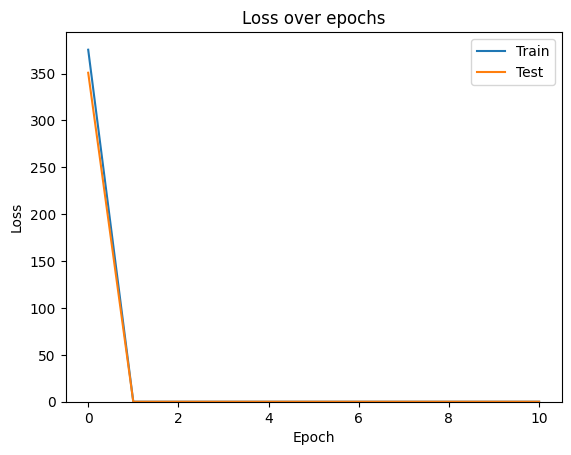

In [23]:
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.ylim(bottom=0)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

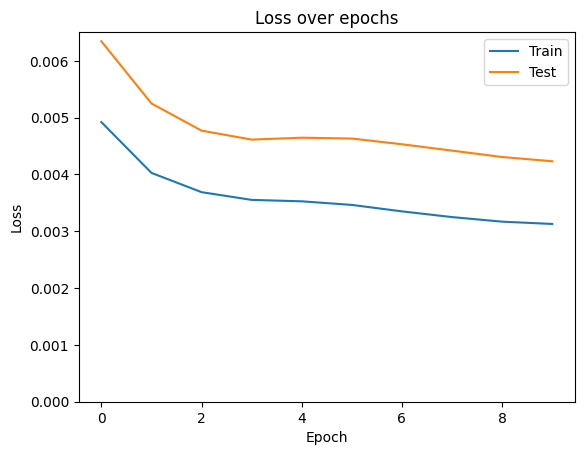

In [24]:
plt.plot(train_loss[1:], label='Train')
plt.plot(test_loss[1:], label='Test')
plt.ylim(bottom=0)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Í VINNSLU

In [25]:
likan.eval()
coordinate_decoder.eval()

with torch.no_grad():
    # Get image embeddings
    image_embeddings = likan.image_encoder(images)

    # Decide on the maximum sequence length you want to generate
    max_seq_length = 20  # Adjust as needed

    # Generate coordinate sequences
    generated_sequences = coordinate_decoder(image_embeddings, max_seq_length)

    # Now 'generated_sequences' contains the predicted coordinates

NameError: name 'images' is not defined

In [ ]:
# Assuming 'generated_sequences' is of shape (batch_size, seq_length, 2)
coordinates = generated_sequences[0].cpu().numpy()  # Get coordinates for the first image

# Plot the coordinates
plt.figure()
plt.plot(coordinates[:, 1], coordinates[:, 0], marker='o')  # Longitude vs Latitude
plt.title('Predicted Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Lokaorð
Greiningin er enn í vinnslu.